## Import Packages

In [9]:
import os
import pandas as pd
import numpy as np
import networkx as nx
from analyze import NetworkAnalysis
from networkx.algorithms import bipartite as bp
import matplotlib.pyplot as plt

# New Test

## Read and Filter Data

In [2]:
path = os.getcwd()
# df = pd.read_csv('data/cleaned_data.csv')
df = pd.read_csv('data/data_example.csv')
# df = pd.read_csv(path+'\\data\\data_example.csv')
df = df.drop(df.columns[0],axis=1)

In [3]:
# userSpace = df[(df.from_address_type == 'EOA') & (df.to_address_type == 'EOA')]
# bipartiteSpace = df[((df.from_address_type == 'EOA') & (df.to_address_type == 'Contract')) | ((df.from_address_type == 'Contract') & (df.to_address_type == 'EOA'))]
# userSpace = userSpace[['from_address','to_address','value']]
# bipartiteSpace = bipartiteSpace[['from_address','to_address','value']]

# a = np.array(userSpace['from_address'])
# b = np.array(userSpace['to_address'])
# c = np.unique(np.vstack((a,b)).flatten())
# len(c)

## Test Complex Plot

<!-- problem: how to fix nodes -->

<!-- nodes
- bottom section: plot all users from monopartite (user) space
- identify intersection of users between monopartite and bipartite space
- top section: plot users outside of intersection from bipartite space
- top section: plot contracts from bipartite space

edges
- draw edges for monopartite space
- draw edges for bipartite space -->

1. plot both GCC networks via class created
    - fix the center of pos for both networks to left and right
2. identify pos of users and contracts from bipartite network
3. plot edges

In [57]:
# ##### sample networks
# sample_network = nx.Graph()
# sample_network.add_nodes_from([0,1,2,3,4], bipartite=0)
# sample_network.add_nodes_from([5,6,7], bipartite=1)
# sample_network.add_edges_from([(0, 5), (1, 7), (2, 7), (3, 6), (4, 7),(0,1),(0,2),(0,4)])

# print(f'network is connected: {nx.is_connected(sample_network)}')
# print(f'network is bipartite: {nx.is_bipartite(sample_network)}')

In [10]:
userSpace = df[(df.from_address_type == 'EOA') & (df.to_address_type == 'EOA')]
bipartiteSpace = df[((df.from_address_type == 'EOA') & (df.to_address_type == 'Contract')) | ((df.from_address_type == 'Contract') & (df.to_address_type == 'EOA'))]
userSpace = userSpace[['from_address','to_address','value']]
bipartiteSpace = bipartiteSpace[['from_address','to_address','value']]

In [11]:
##### generate networks
network_analysis_obj = NetworkAnalysis(df)
monopartite_full = network_analysis_obj.gen_network(network_type='monopartite_full')
bipartite_full = network_analysis_obj.gen_network(network_type='bipartite_full')

In [6]:
##### identify and filter out intersecting user nodes between monopartite and bipartite
monopartite_full_nodes = list(monopartite_full.nodes())
subsetBipartiteSpace = bipartiteSpace[~bipartiteSpace['from_address'].isin(monopartite_full_nodes)]

##### generate subset of bipartite network
bipartite_subset_users = np.unique(np.array(subsetBipartiteSpace['from_address']))
bipartite_subset_contracts = np.unique(np.array(subsetBipartiteSpace['to_address']))
bipartite_subset_edges = list(zip(subsetBipartiteSpace['from_address'], subsetBipartiteSpace['to_address']))

bipartite_subset = nx.Graph()
bipartite_subset.add_nodes_from(bipartite_subset_users, bipartite=0)
bipartite_subset.add_nodes_from(bipartite_subset_contracts, bipartite=1)
bipartite_subset.add_edges_from(bipartite_subset_edges)

##### generate network between monopartite and bipartite
monoBiSpace = bipartiteSpace[bipartiteSpace['from_address'].isin(monopartite_full_nodes)]

bipartite_intersect_users = np.unique(np.array(monoBiSpace['from_address']))
bipartite_intersect_contracts = np.unique(np.array(monoBiSpace['to_address']))
bipartite_intersect_edges = list(zip(monoBiSpace['from_address'], monoBiSpace['to_address']))

bipartite_intersect = nx.Graph()
bipartite_intersect.add_nodes_from(bipartite_intersect_users, bipartite=0)
bipartite_intersect.add_nodes_from(bipartite_intersect_contracts, bipartite=1)
bipartite_intersect.add_edges_from(bipartite_intersect_edges)

monopartite_full network is connected: False
bipartite_subset network is connected: False
bipartite_subset network is bipartite: True
bipartite_intersect network is connected: True
bipartite_intersect network is bipartite: True


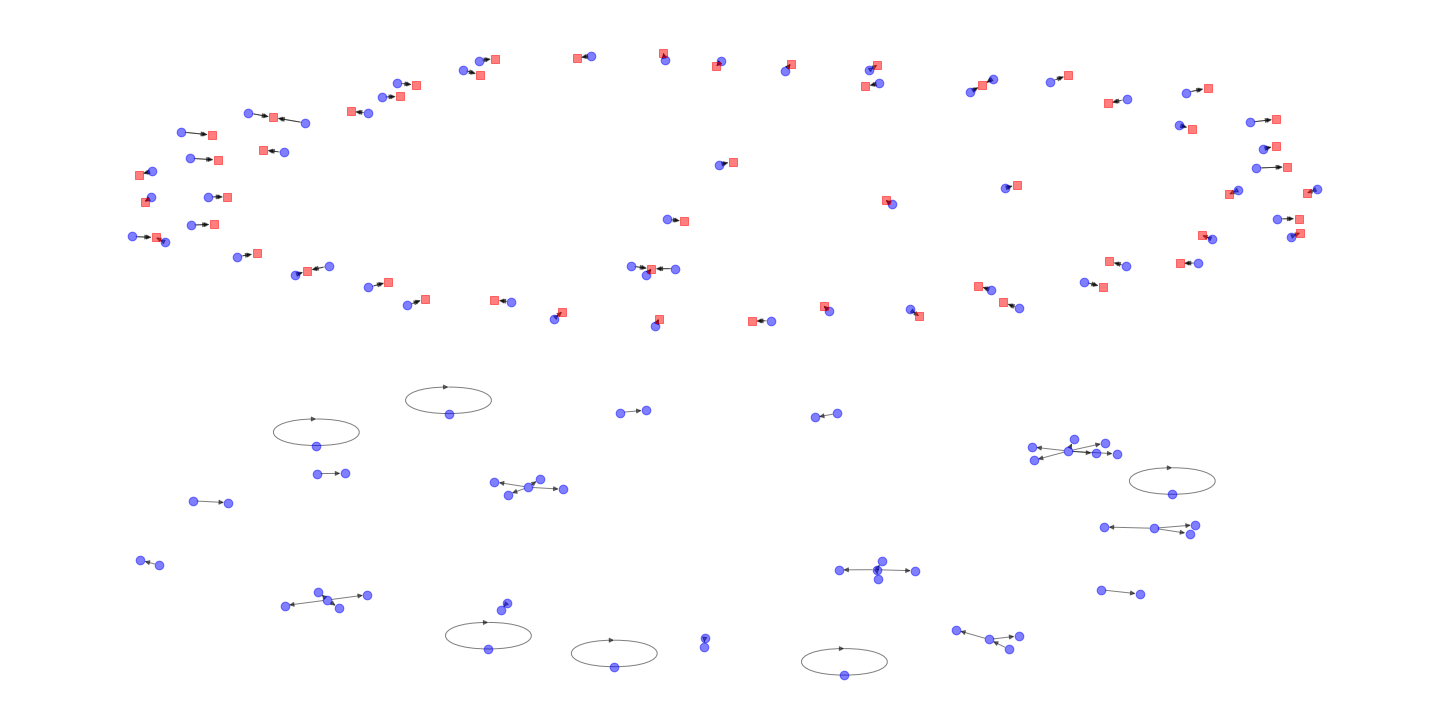

In [7]:
##### aesthetic variables
seed = 100; user_color = 'blue'; contract_color = 'red'
node_size = 75; contract_node_shape = 's'; alpha = 0.5
center_shift = 1.25

fig = plt.figure(figsize=(20, 10), constrained_layout=True)

##### plot monopartite
ax1 = fig.add_subplot(111)
network_type = 'monopartite_full'
network = monopartite_full
print(f'{network_type} network is connected: {nx.is_connected(network)}')

monopartite_pos=nx.spring_layout(network, seed = seed, center=(0,center_shift*-1))
nx.draw(network,monopartite_pos,arrows=True,node_size=node_size,
                    node_color=user_color, alpha=alpha, with_labels=False)    

##### plot subset of bipartite
network_type = 'bipartite_subset'
network = bipartite_subset
print(f'{network_type} network is connected: {nx.is_connected(network)}')
print(f'{network_type} network is bipartite: {nx.is_bipartite(network)}')

subset_users=[]; subset_contracts=[]
for node in network.nodes(data=True):
    address = node[0]
    attribute = node[1]['bipartite']
    if attribute == 0:
        subset_users.append(address)
    else:
        subset_contracts.append(address)

bipartite_subset_pos = nx.spring_layout(network, seed = seed, center=(0,center_shift))
# draw the network - user nodes
nx.draw(network,bipartite_subset_pos,arrows=True,nodelist=list(subset_users),
        node_color=user_color,alpha=alpha,node_size=node_size, with_labels=False)
# draw the network - contract nodes
nx.draw(network,bipartite_subset_pos,arrows=True,nodelist=list(subset_contracts),
        node_color=contract_color,alpha=alpha,node_shape=contract_node_shape,node_size=node_size)

##### plot intersect of bipartite 
network_type = 'bipartite_intersect'
network = bipartite_intersect
print(f'{network_type} network is connected: {nx.is_connected(network)}')
print(f'{network_type} network is bipartite: {nx.is_bipartite(network)}')

# TO DO: identify positions of user nodes from monopartite and contract nodes from bipartite using list of addresses
# 1. monopartite_pos
# 2. bipartite_subset_pos

# BEWARE: check whether contract addresses are mising from bipartite_subset network when creating bipartite_intersect network

# pos = 
# draw_networkx_edges(network, pos)

plt.show()

In [8]:
all_pos=[]

for node in bipartite_intersect.nodes(data=True):
    address = node[0]
    attribute = node[1]['bipartite']
    print(address)
    if attribute == 0:
        coordinate = monopartite_pos[address]
        print(coordinate)
        all_pos.append(coordinate)


0xddfabcdc4d8ffc6d5beaf154f18b778f892a0740
[ 0.25363695 -1.49408293]
0xde30da39c46104798bb5aa3fe8b9e0e1f348163f


In [9]:
subsetBipartiteSpace[subsetBipartiteSpace['from_address'] == '0xde30da39c46104798bb5aa3fe8b9e0e1f348163f']

,from_address,to_address,value


## Test Class

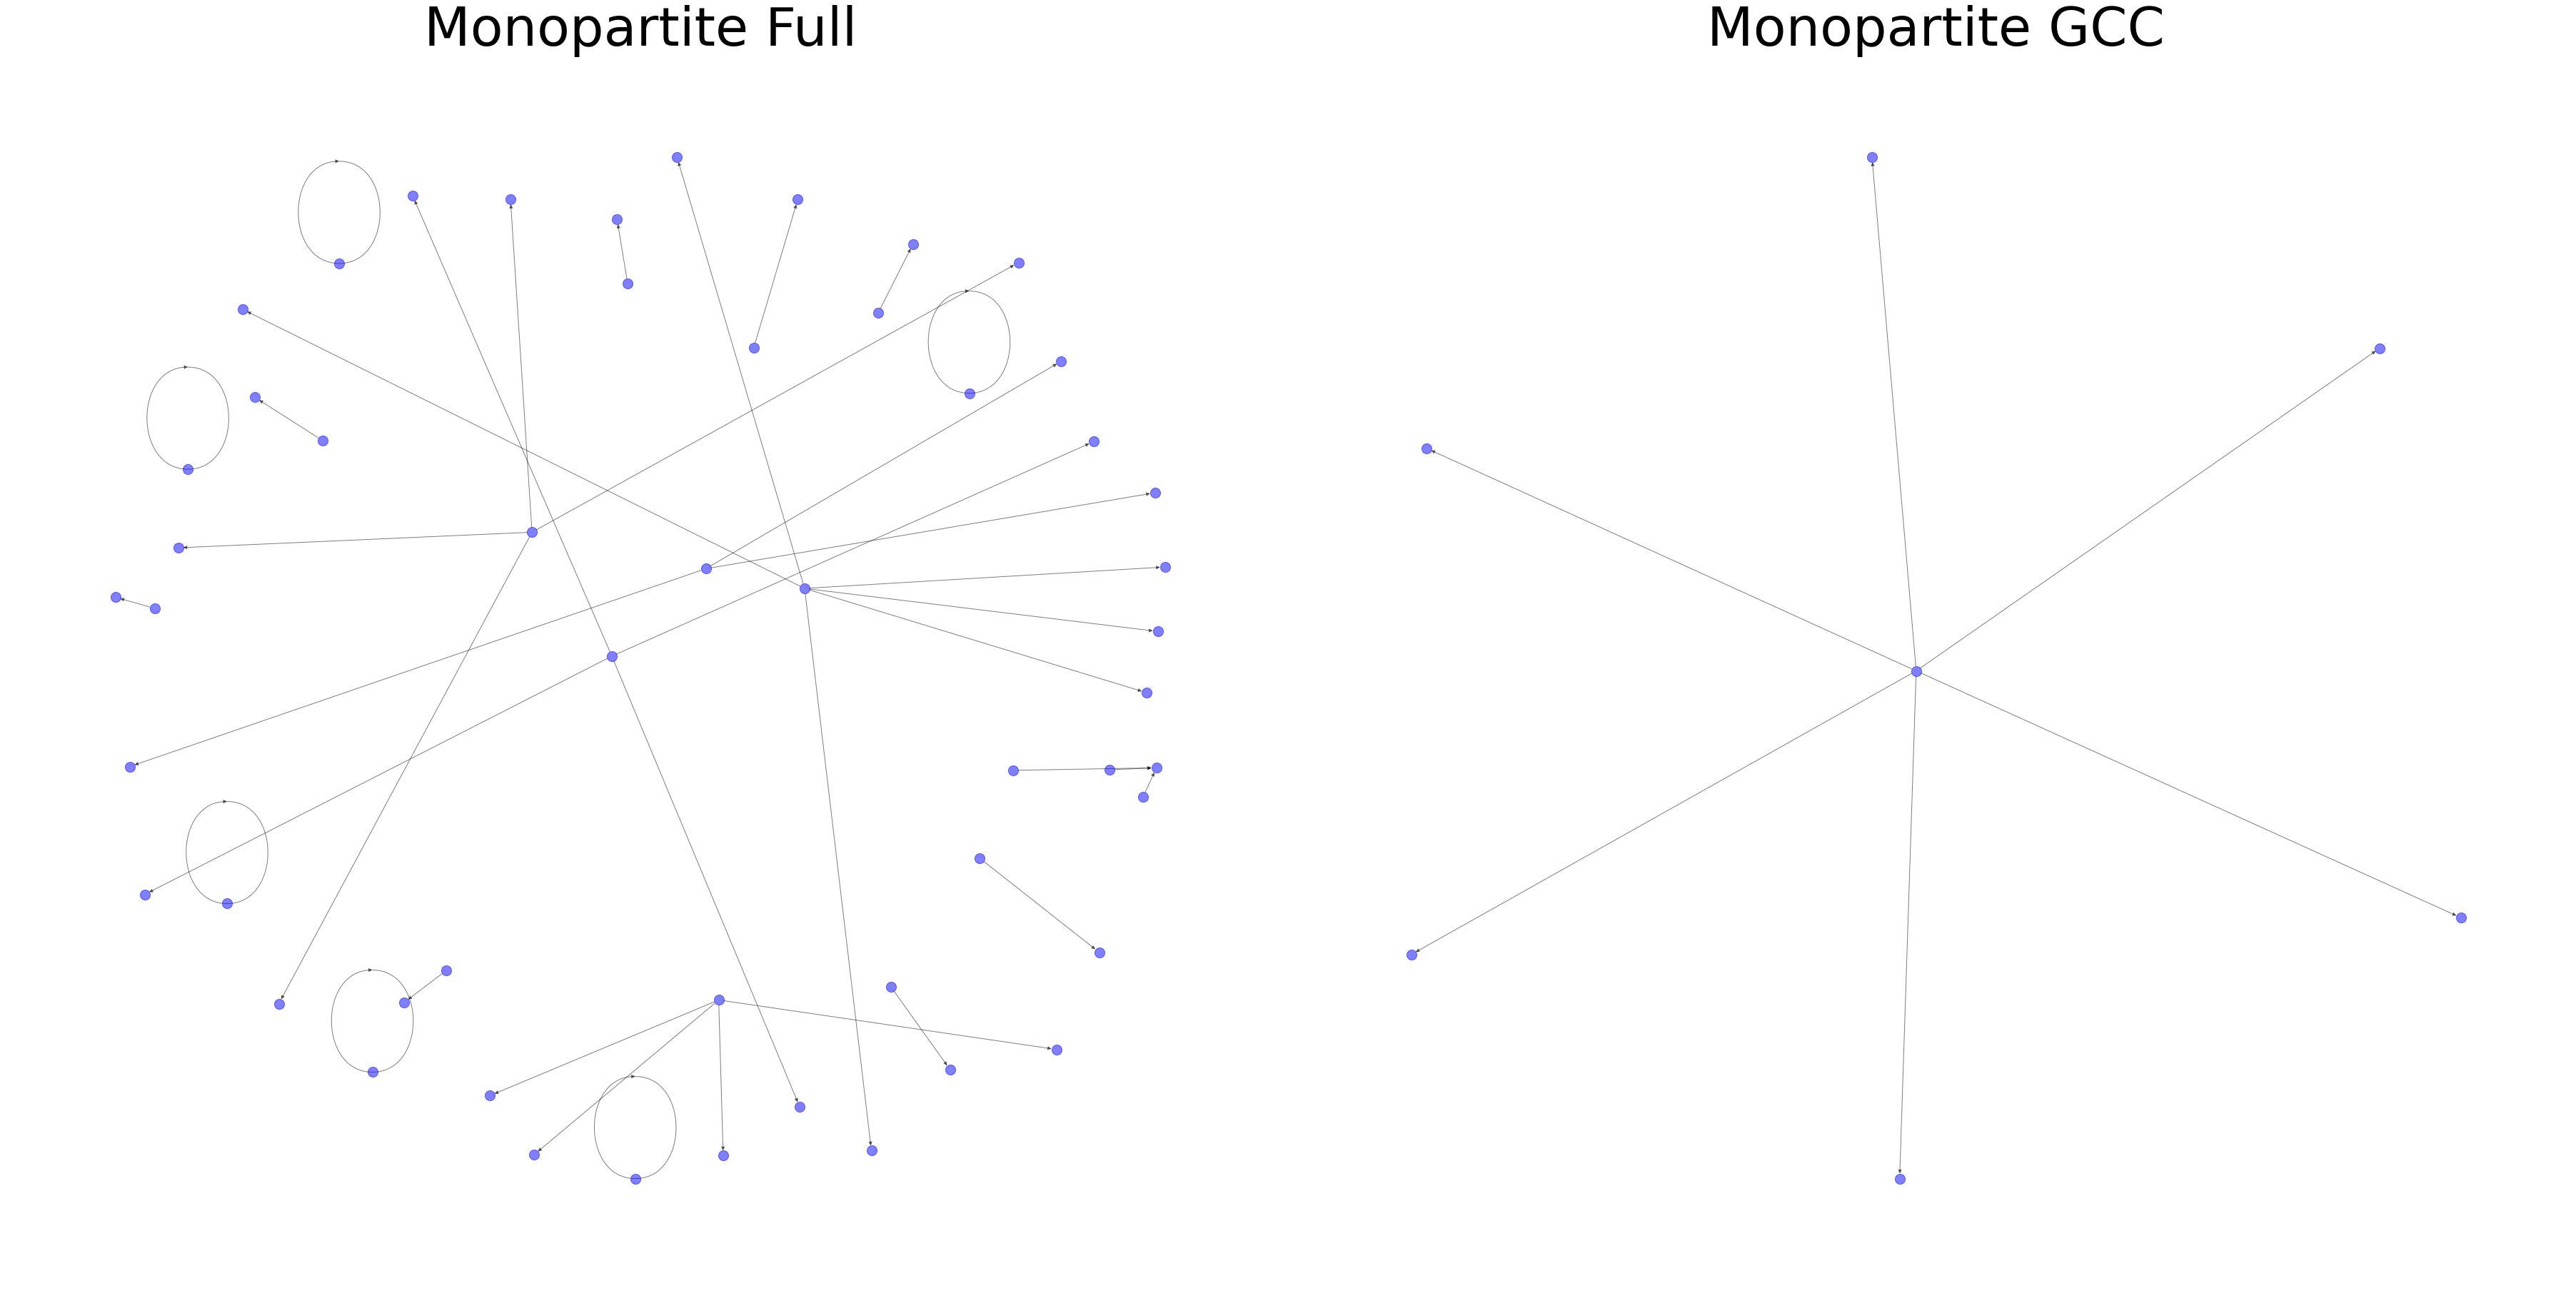

In [3]:
network_analysis_obj = NetworkAnalysis(df)
monopartite_full = network_analysis_obj.gen_network(network_type='monopartite_full')
monopartite_gcc = network_analysis_obj.gen_network(network_type='monopartite_gcc')

fig = plt.figure(figsize=(50, 25), constrained_layout=True)
ax1 = fig.add_subplot(121)
network_analysis_obj.plot_network(monopartite_full, network_type='monopartite_full')
ax1.set_title('Monopartite Full', fontdict={'fontsize': 75})

ax2 = fig.add_subplot(122)
network_analysis_obj.plot_network(monopartite_gcc, network_type='monopartite_gcc')
ax2.set_title('Monopartite GCC', fontdict={'fontsize': 75})

plt.show()

bipartite_full network is bipartite: True
bipartite_gcc network is bipartite: True


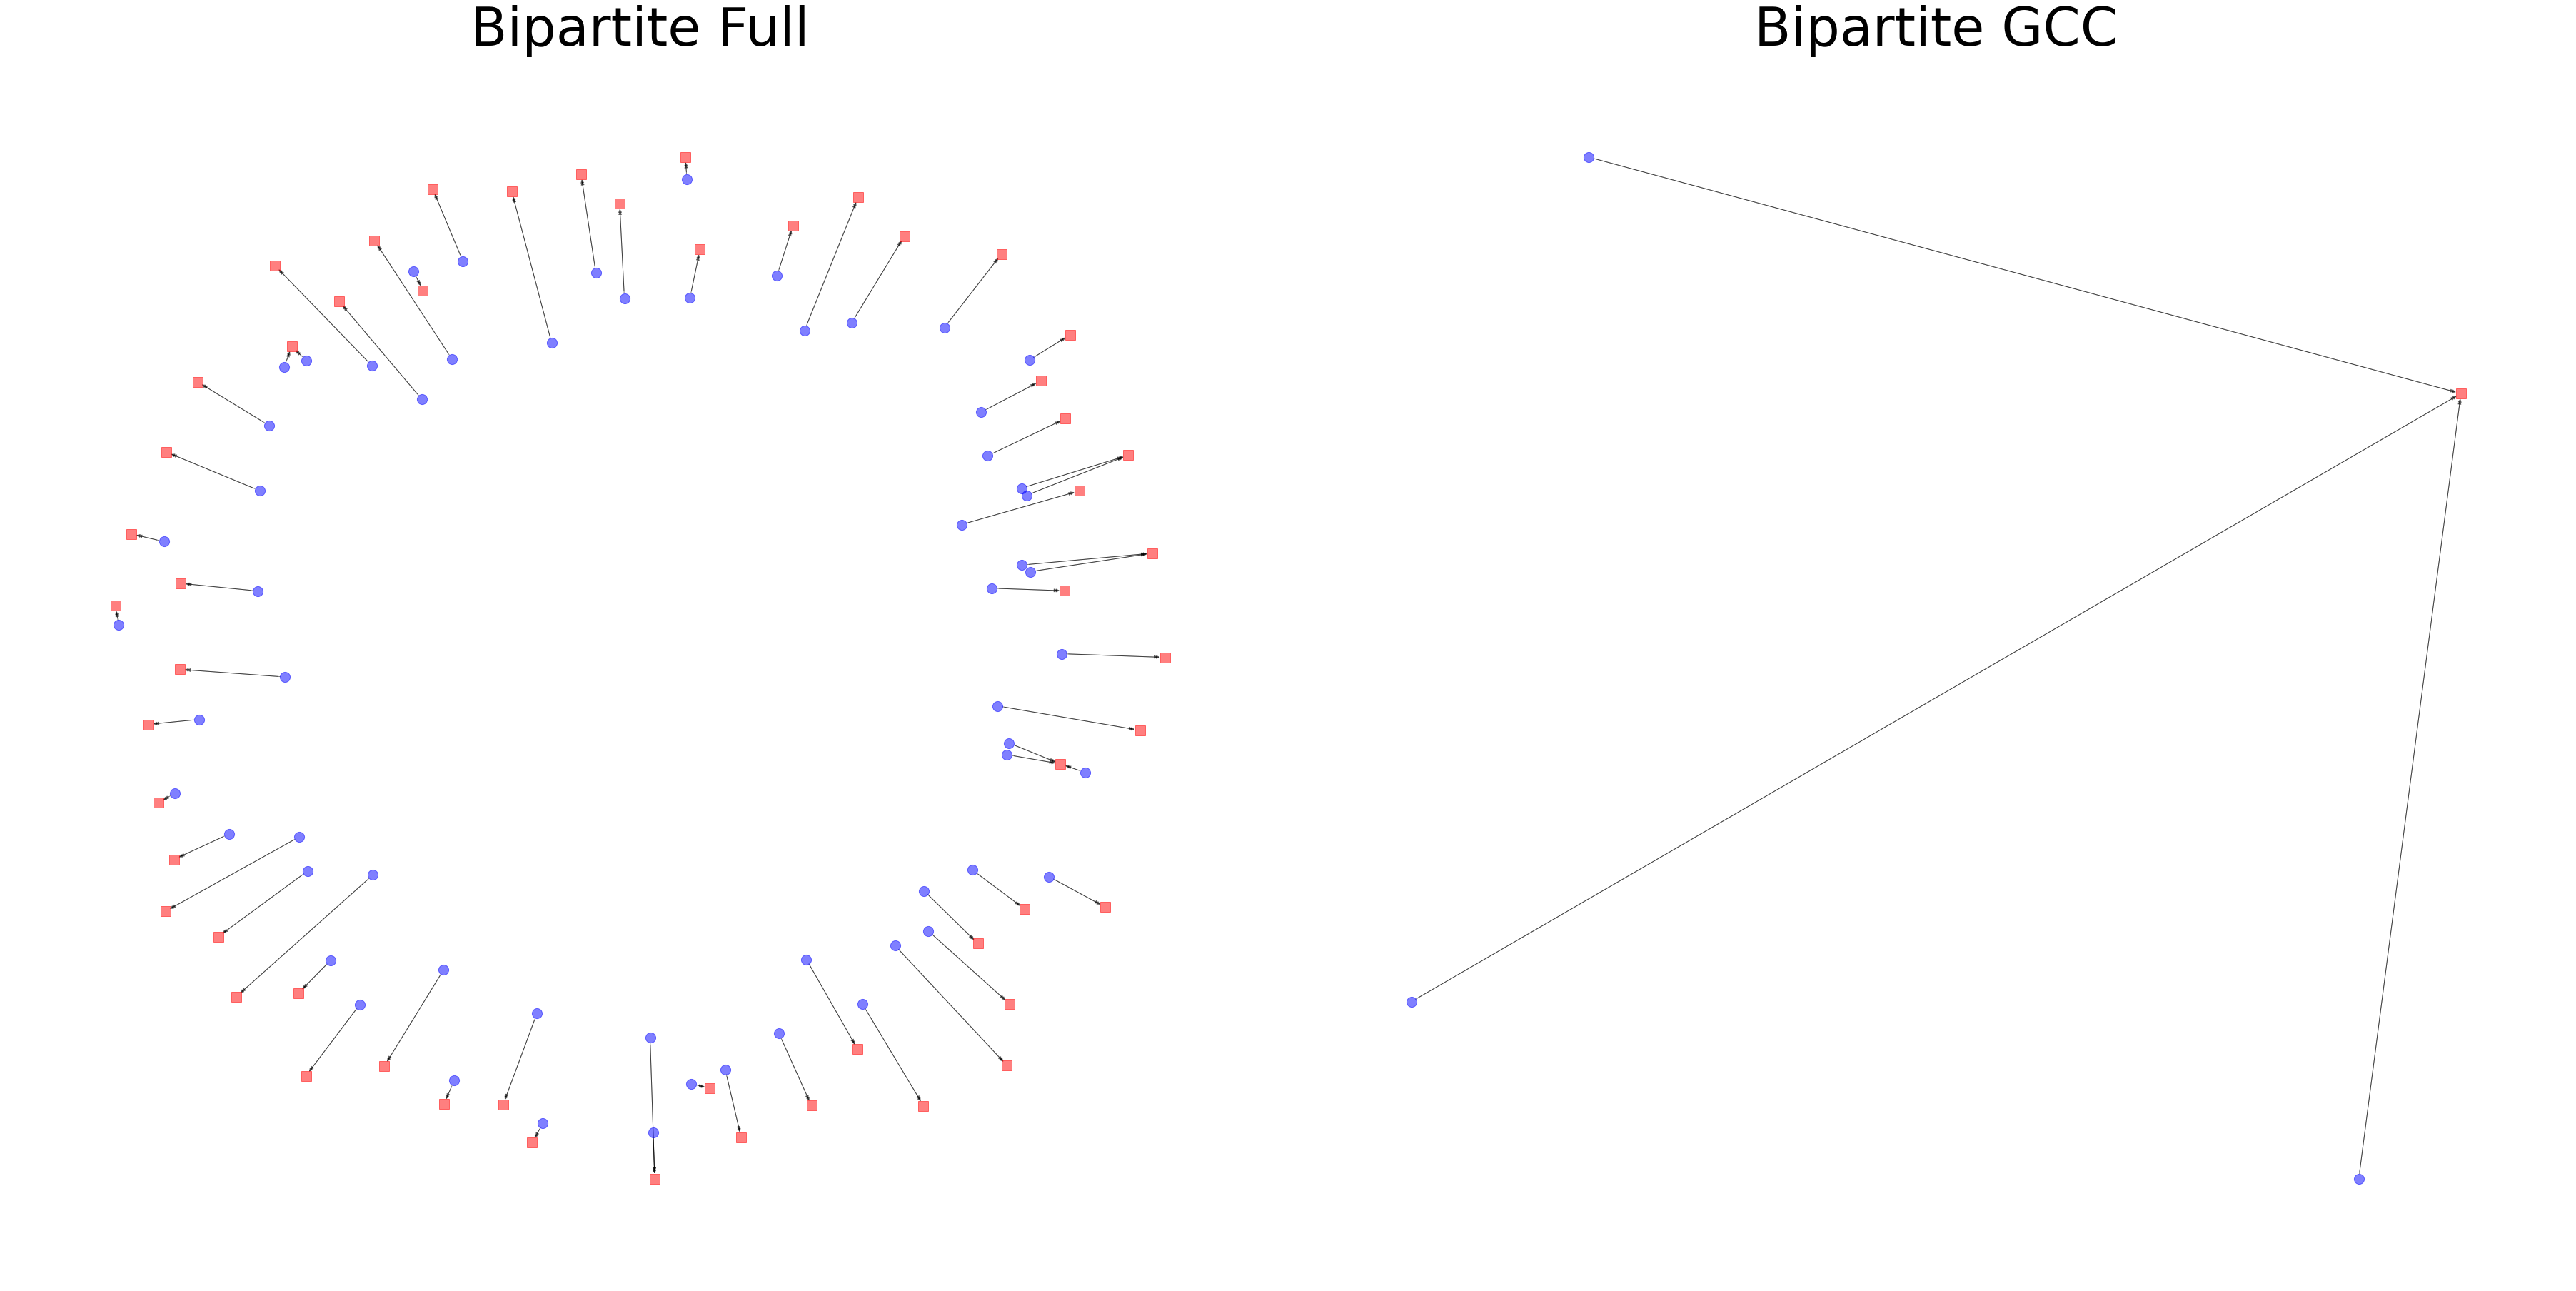

In [4]:
network_analysis_obj = NetworkAnalysis(df)
bipartite_full = network_analysis_obj.gen_network(network_type='bipartite_full')
bipartite_gcc = network_analysis_obj.gen_network(network_type='bipartite_gcc')

fig = plt.figure(figsize=(50, 25), constrained_layout=True)
ax1 = fig.add_subplot(121)
network_analysis_obj.plot_network(bipartite_full, network_type='bipartite_full')
ax1.set_title('Bipartite Full', fontdict={'fontsize': 75})

ax2 = fig.add_subplot(122)
network_analysis_obj.plot_network(bipartite_gcc, network_type='bipartite_gcc')
ax2.set_title('Bipartite GCC', fontdict={'fontsize': 75})

plt.show()

# Old Testing

## Test Monopartite

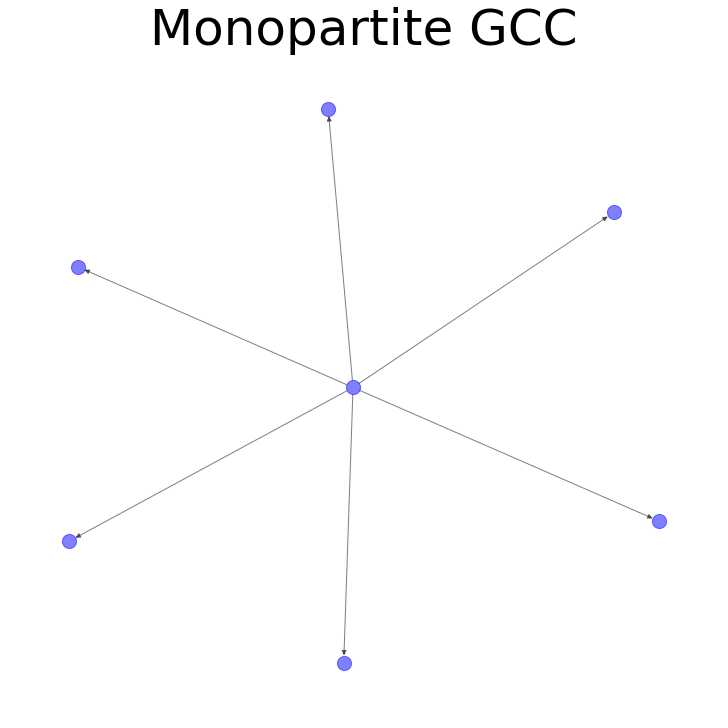

In [9]:
G = nx.from_pandas_edgelist(userSpace,            # the df containing the data
                    source='from_address',        # first element of the dyad
                    target='to_address',          # second element of the dyad
                    edge_attr='value')#,create_using=nx.DiGraph()

gcc = list(max(nx.connected_components(G), key=lambda x: len(x)))
gcc_df = userSpace[userSpace['from_address'].isin(gcc) | userSpace['to_address'].isin(gcc)]


network = nx.from_pandas_edgelist(gcc_df,            # the df containing the data
                    source='from_address',        # first element of the dyad
                    target='to_address',          # second element of the dyad
                    edge_attr='value',create_using=nx.DiGraph())

fig = plt.figure(figsize=(10, 10), constrained_layout=True)
ax1 = fig.add_subplot(111)

seed = 100; user_color = 'blue'; contract_color = 'red'
node_size = 200; contract_node_shape = 's'; alpha = 0.5

pos=nx.spring_layout(network, seed = seed)
nx.draw(network,pos,arrows=True,node_size=node_size,
                    node_color=user_color, alpha=alpha)

ax1.set_title('Monopartite GCC', fontdict={'fontsize': 50})

plt.show()

## Old - Plot User Space Network

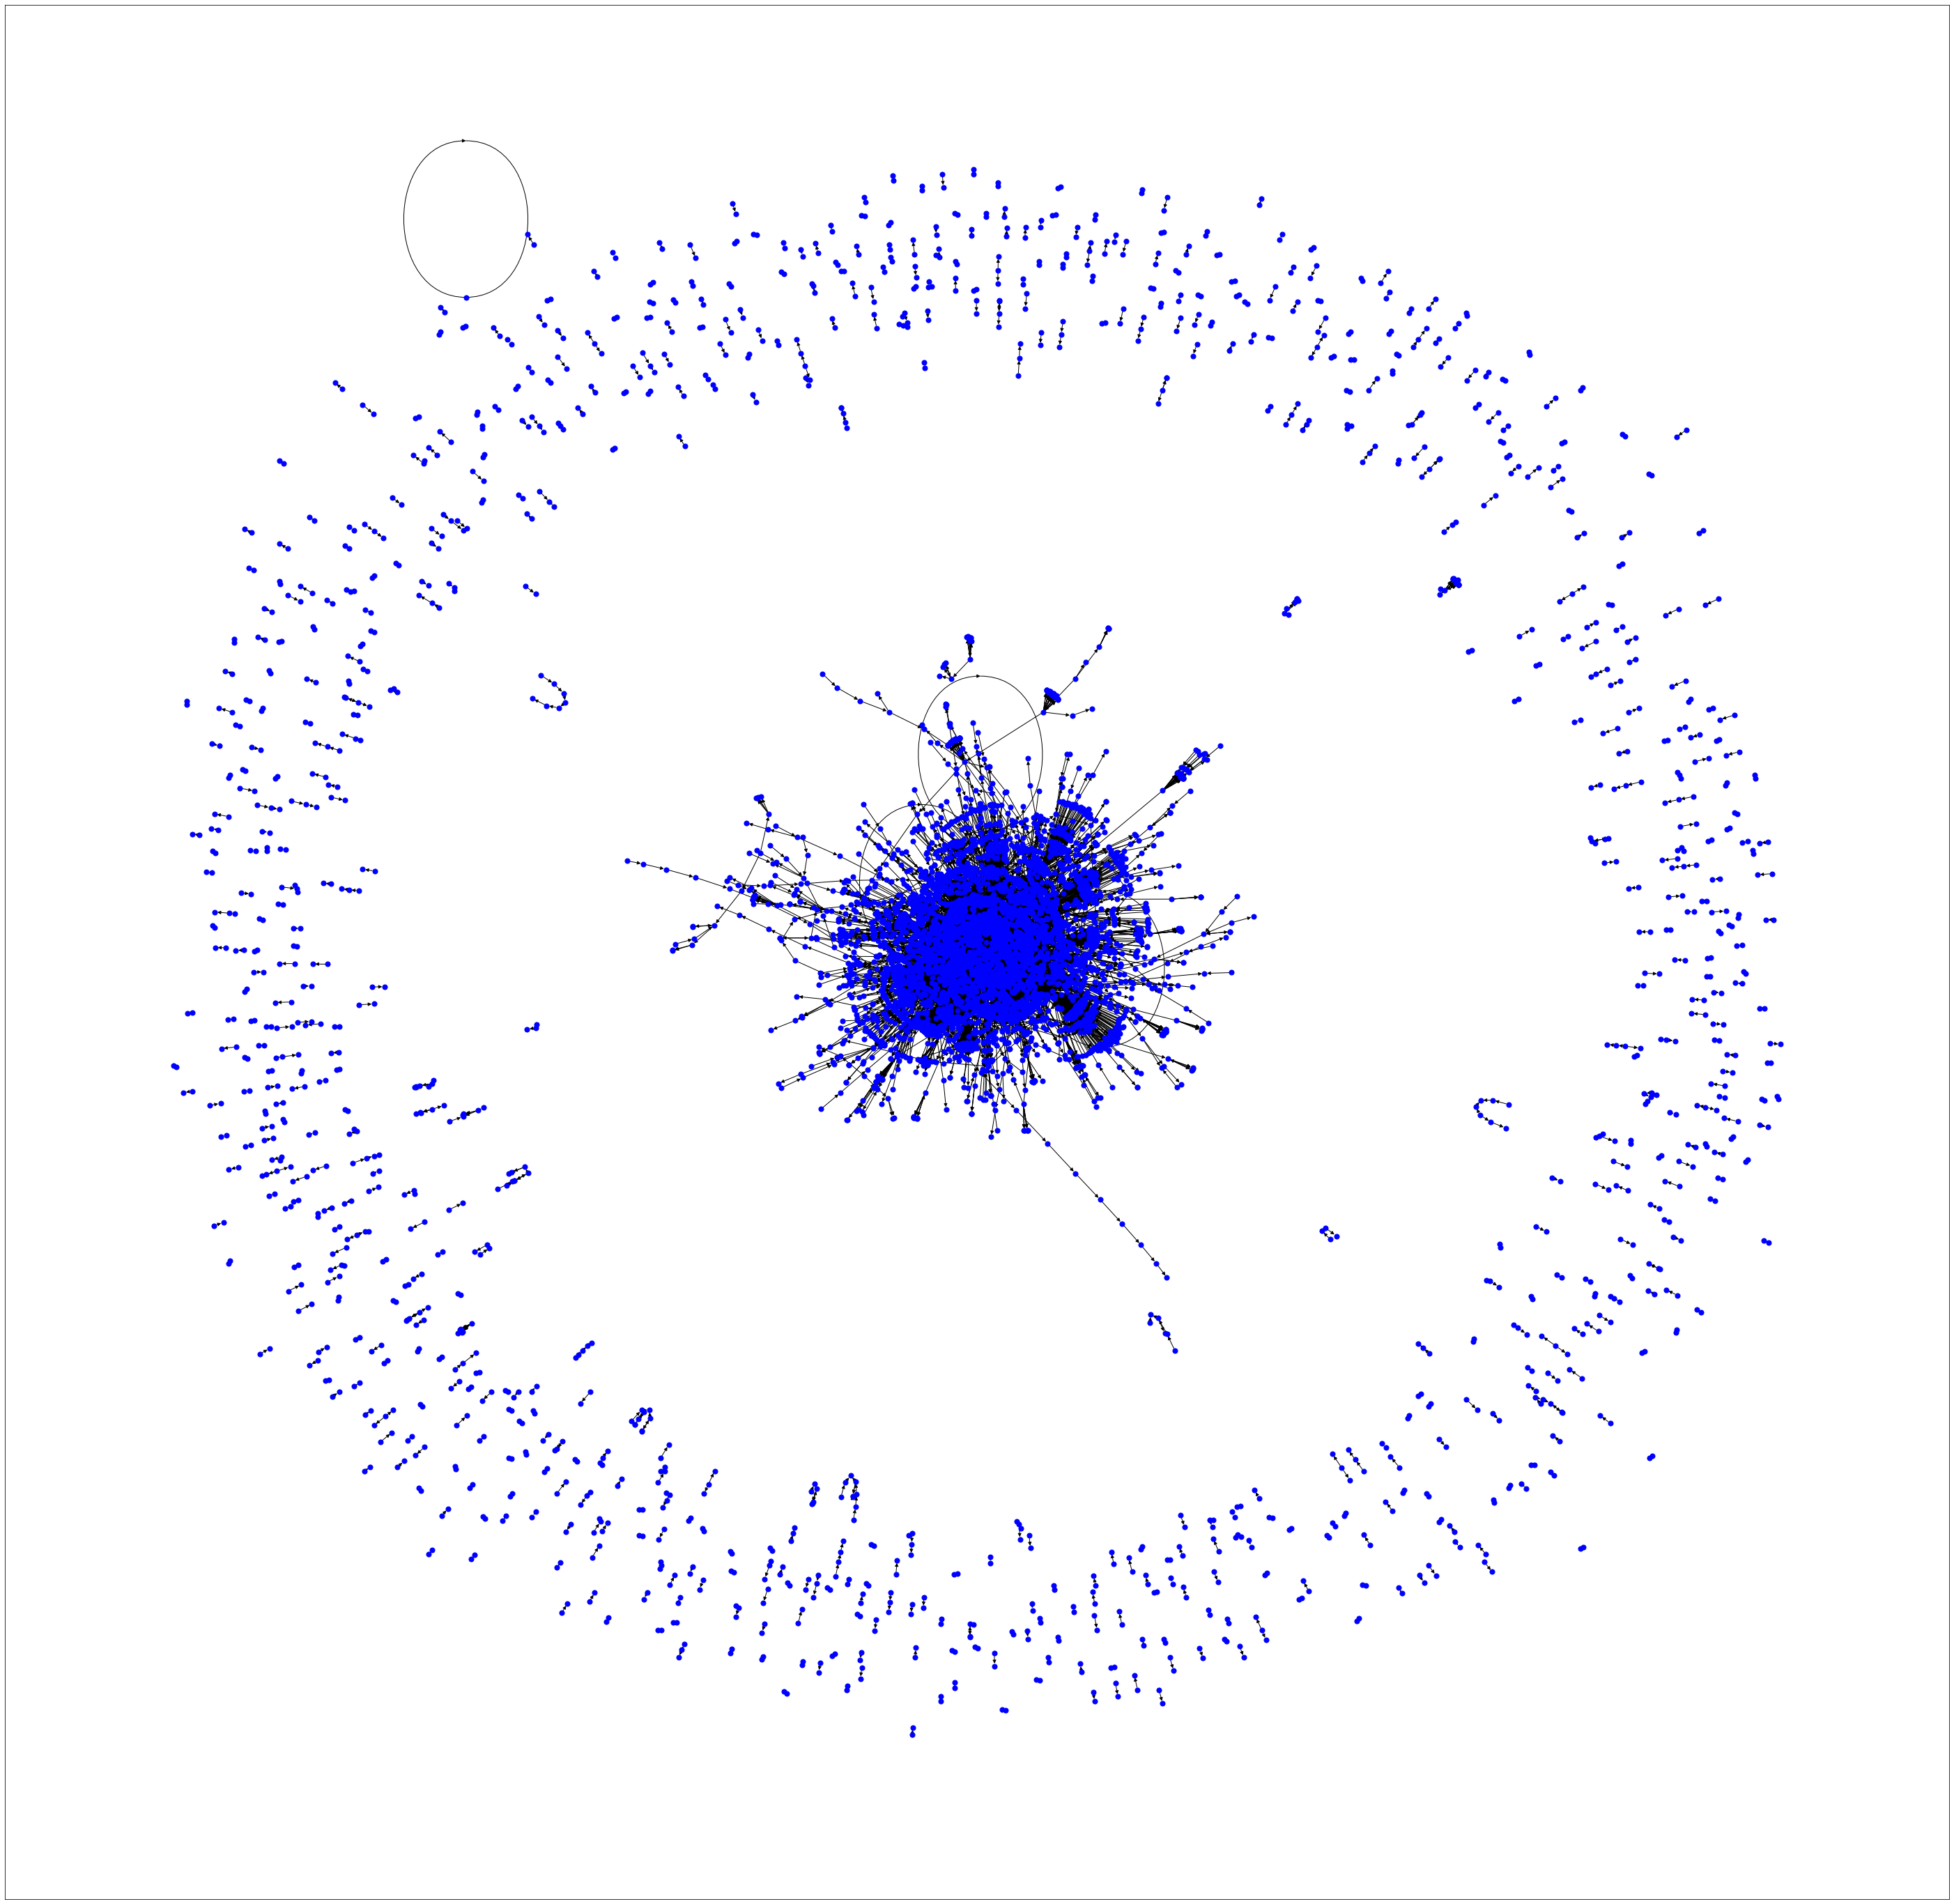

In [6]:
classObj = NetworkAnalysis(userSpace)
classObj.plot_network(classObj.gen_network())

## Bipartite Test 1

In [18]:
G = nx.Graph()
G.add_nodes_from(np.unique(np.array(bipartiteSpace['from_address'])), bipartite=0)
G.add_nodes_from(np.unique(np.array(bipartiteSpace['to_address'])), bipartite=1)
G.add_edges_from(list(zip(bipartiteSpace['from_address'], bipartiteSpace['to_address'])))

In [19]:
nx.is_connected(G)

False

In [20]:
nx.is_bipartite(G)

True

In [21]:
print("# of unique from_address: "+str(len(bipartiteSpace['from_address'].unique())))
print("# of unique to_address: "+str(len(bipartiteSpace['to_address'].unique())))

# of unique from_address: 5704
# of unique to_address: 738


In [22]:
users = np.unique(np.array(bipartiteSpace['from_address']))
contracts = np.unique(np.array(bipartiteSpace['to_address']))
edges = list(zip(bipartiteSpace['from_address'], bipartiteSpace['to_address']))

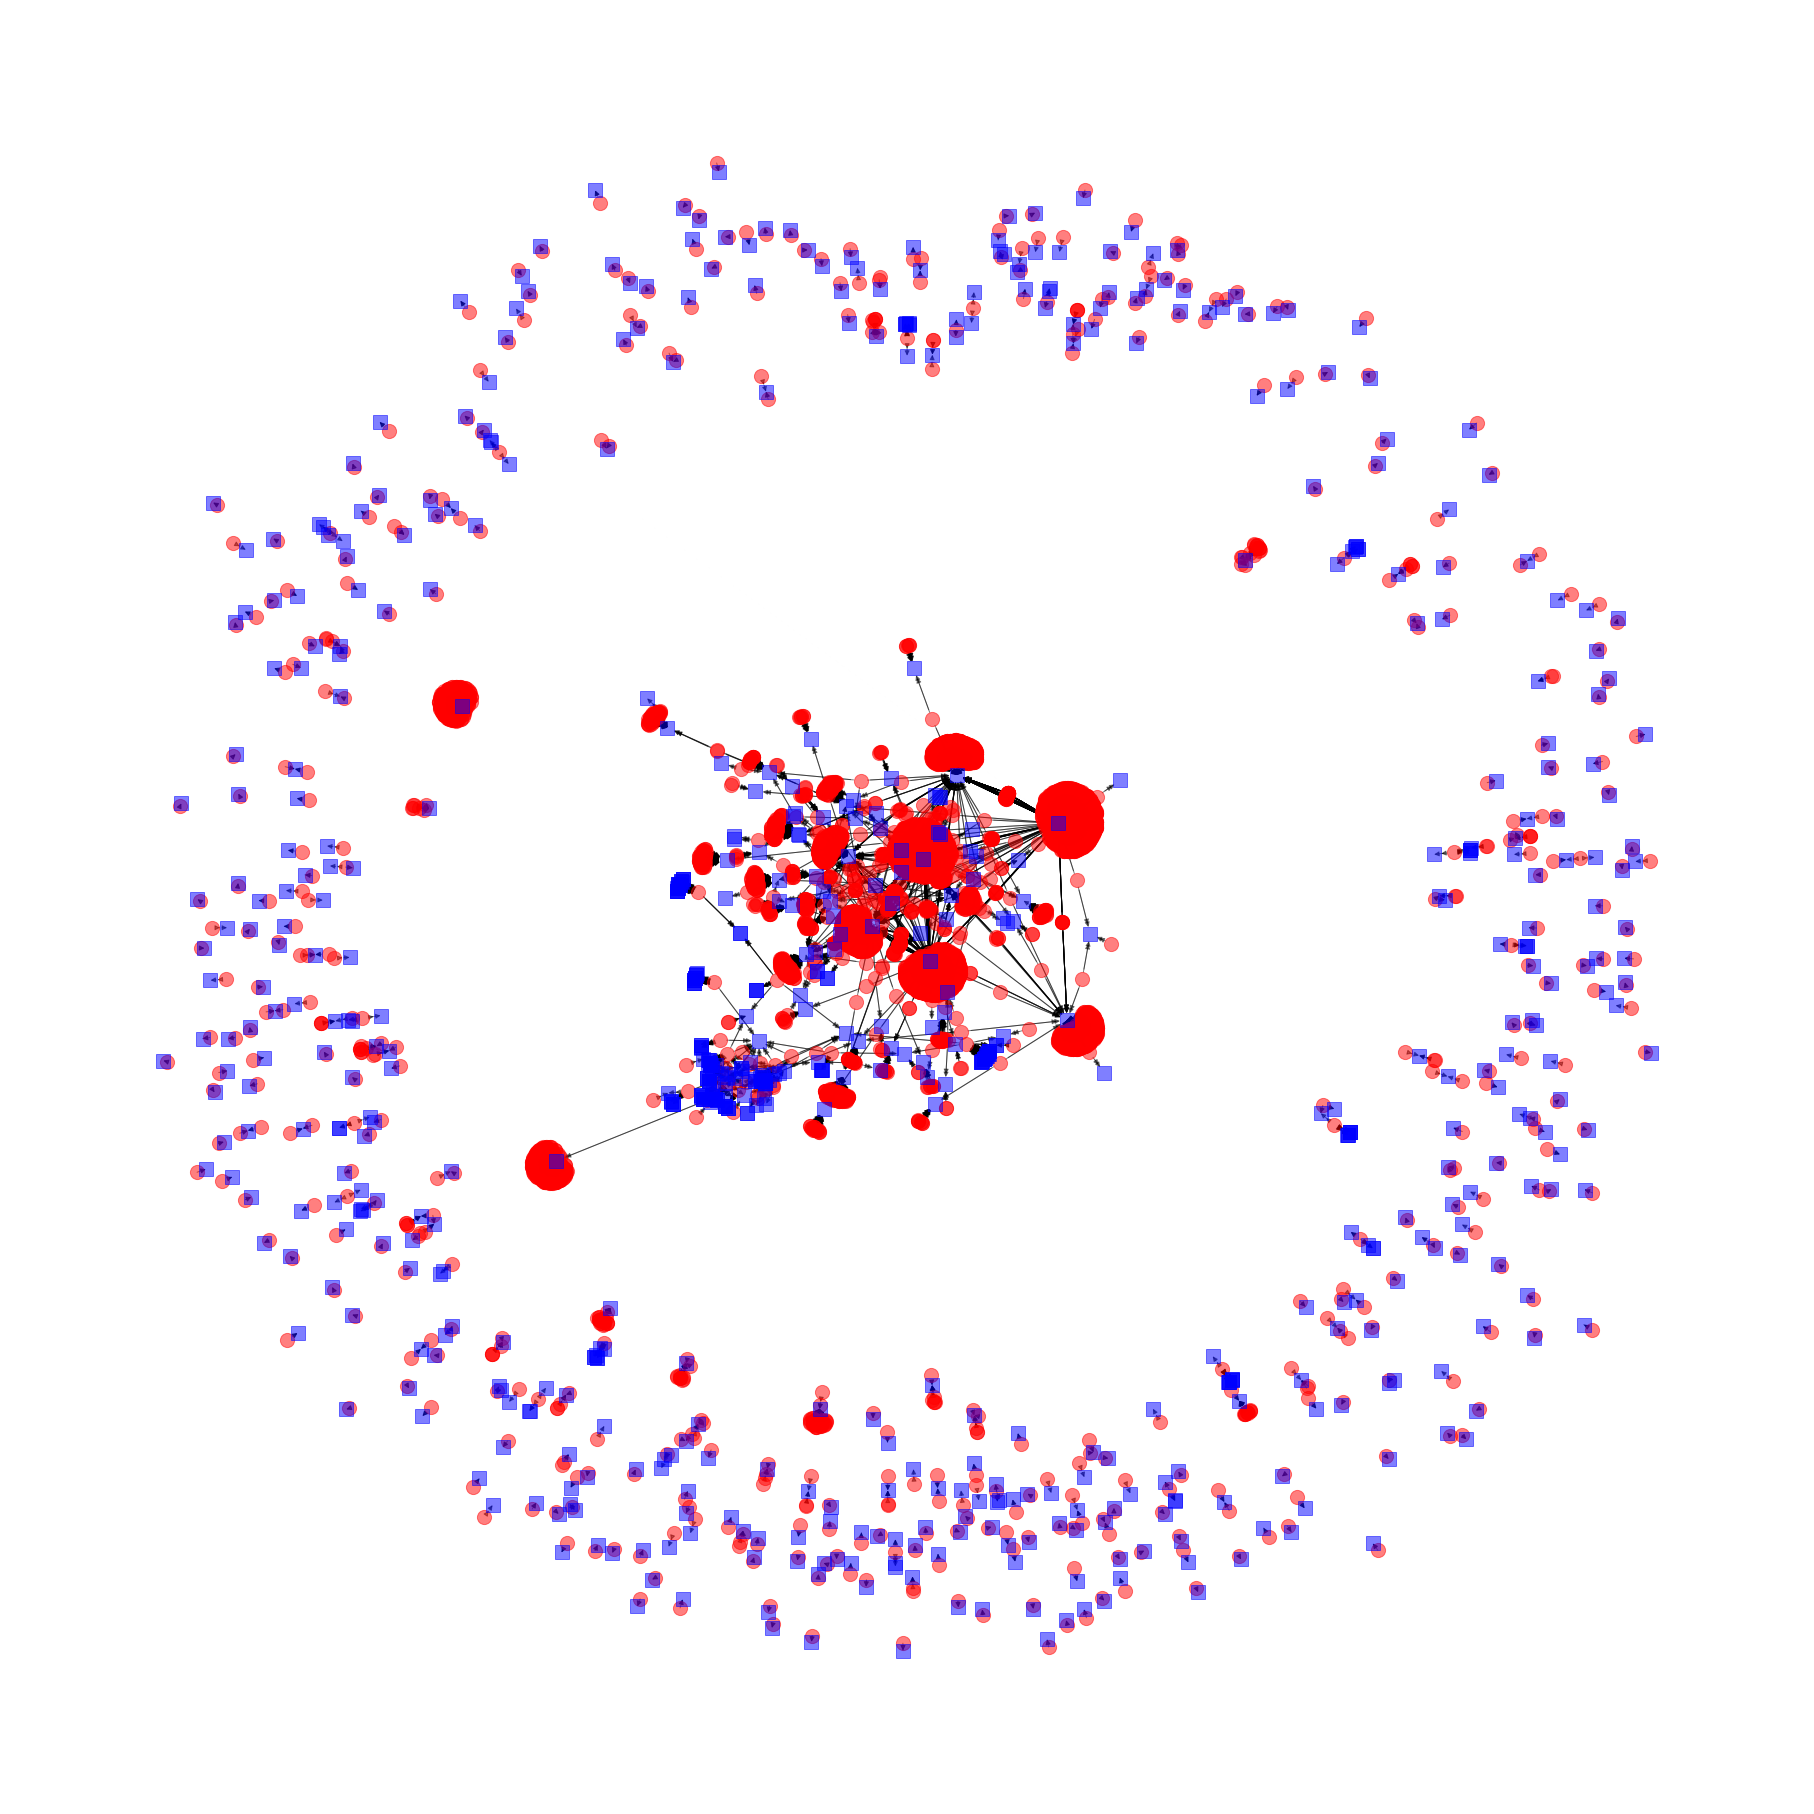

In [23]:
plt.figure(figsize=(25, 25))
pos = nx.spring_layout(G)       

# draw the network - user nodes
nx.draw(G,pos,arrows=True,nodelist=list(users),
        node_color='red',alpha=0.5,node_size=200)
# draw the network - contract nodes
nx.draw(G,pos,arrows=True,nodelist=list(contracts),
        node_color='blue',alpha=0.5,node_shape='s',node_size=200)
plt.show()

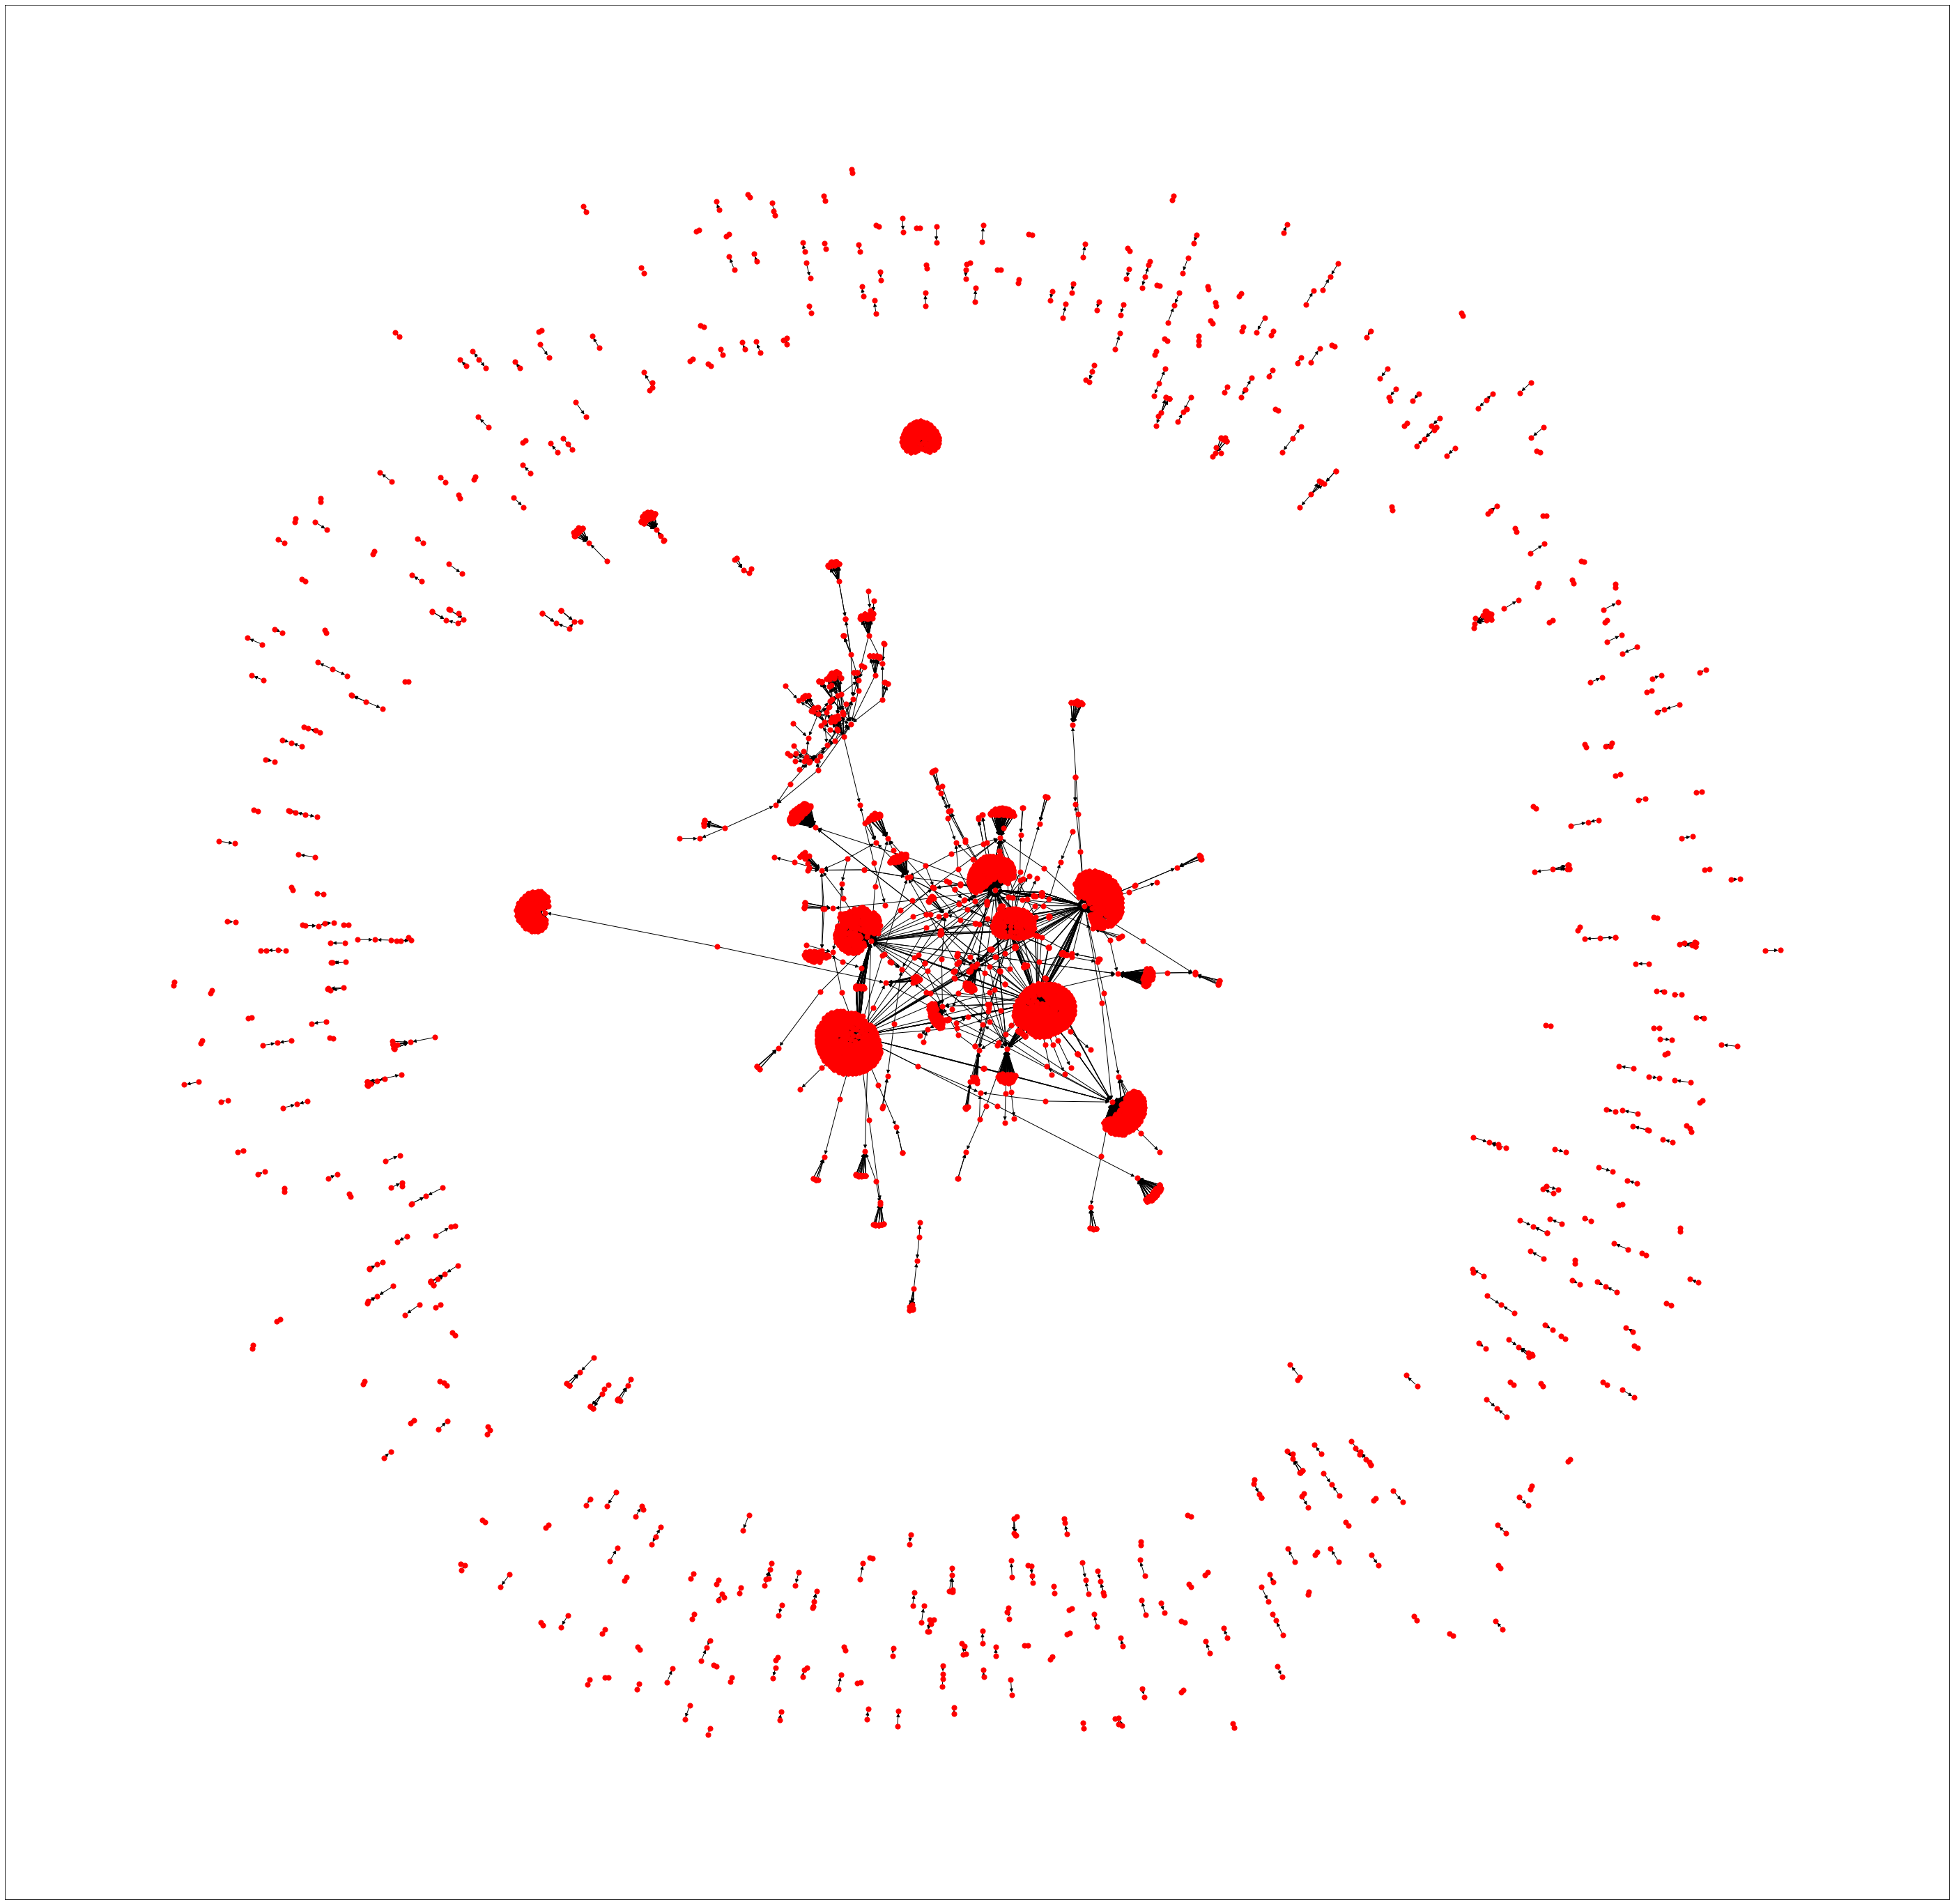

In [11]:
plt.figure(figsize=(40, 40))
pos=nx.spring_layout(G) #, k=0.15
nx.draw_networkx(G,pos,arrows=True, node_color='red',node_size=250, with_labels=False) #, node_color='blue'
plt.show()

## Bipartite Test 2

In [11]:
users = np.unique(np.array(bipartiteSpace['from_address']))
contracts = np.unique(np.array(bipartiteSpace['to_address']))
edges = list(zip(bipartiteSpace['from_address'], bipartiteSpace['to_address']))

In [12]:
B = nx.Graph()
B.add_nodes_from(users, bipartite=0)
B.add_nodes_from(contracts, bipartite=1)
B.add_edges_from(edges)

In [13]:
gcc = list(max(nx.connected_components(B), key=lambda x: len(x)))
# all_nodes = list(B.nodes())
# remove_nodes = list(set(all_nodes) - set(gcc))

In [14]:
gcc_df = bipartiteSpace[bipartiteSpace['from_address'].isin(gcc) | bipartiteSpace['to_address'].isin(gcc)]
gcc_users = np.unique(np.array(gcc_df['from_address']))
gcc_contracts = np.unique(np.array(gcc_df['to_address']))
gcc_edges = list(zip(gcc_df['from_address'], gcc_df['to_address']))

In [19]:
B = nx.Graph(seed=1)
B.add_nodes_from(gcc_users, bipartite=0)
B.add_nodes_from(gcc_contracts, bipartite=1)
B.add_edges_from(gcc_edges)

pos=nx.spring_layout(B)#, k=0.15

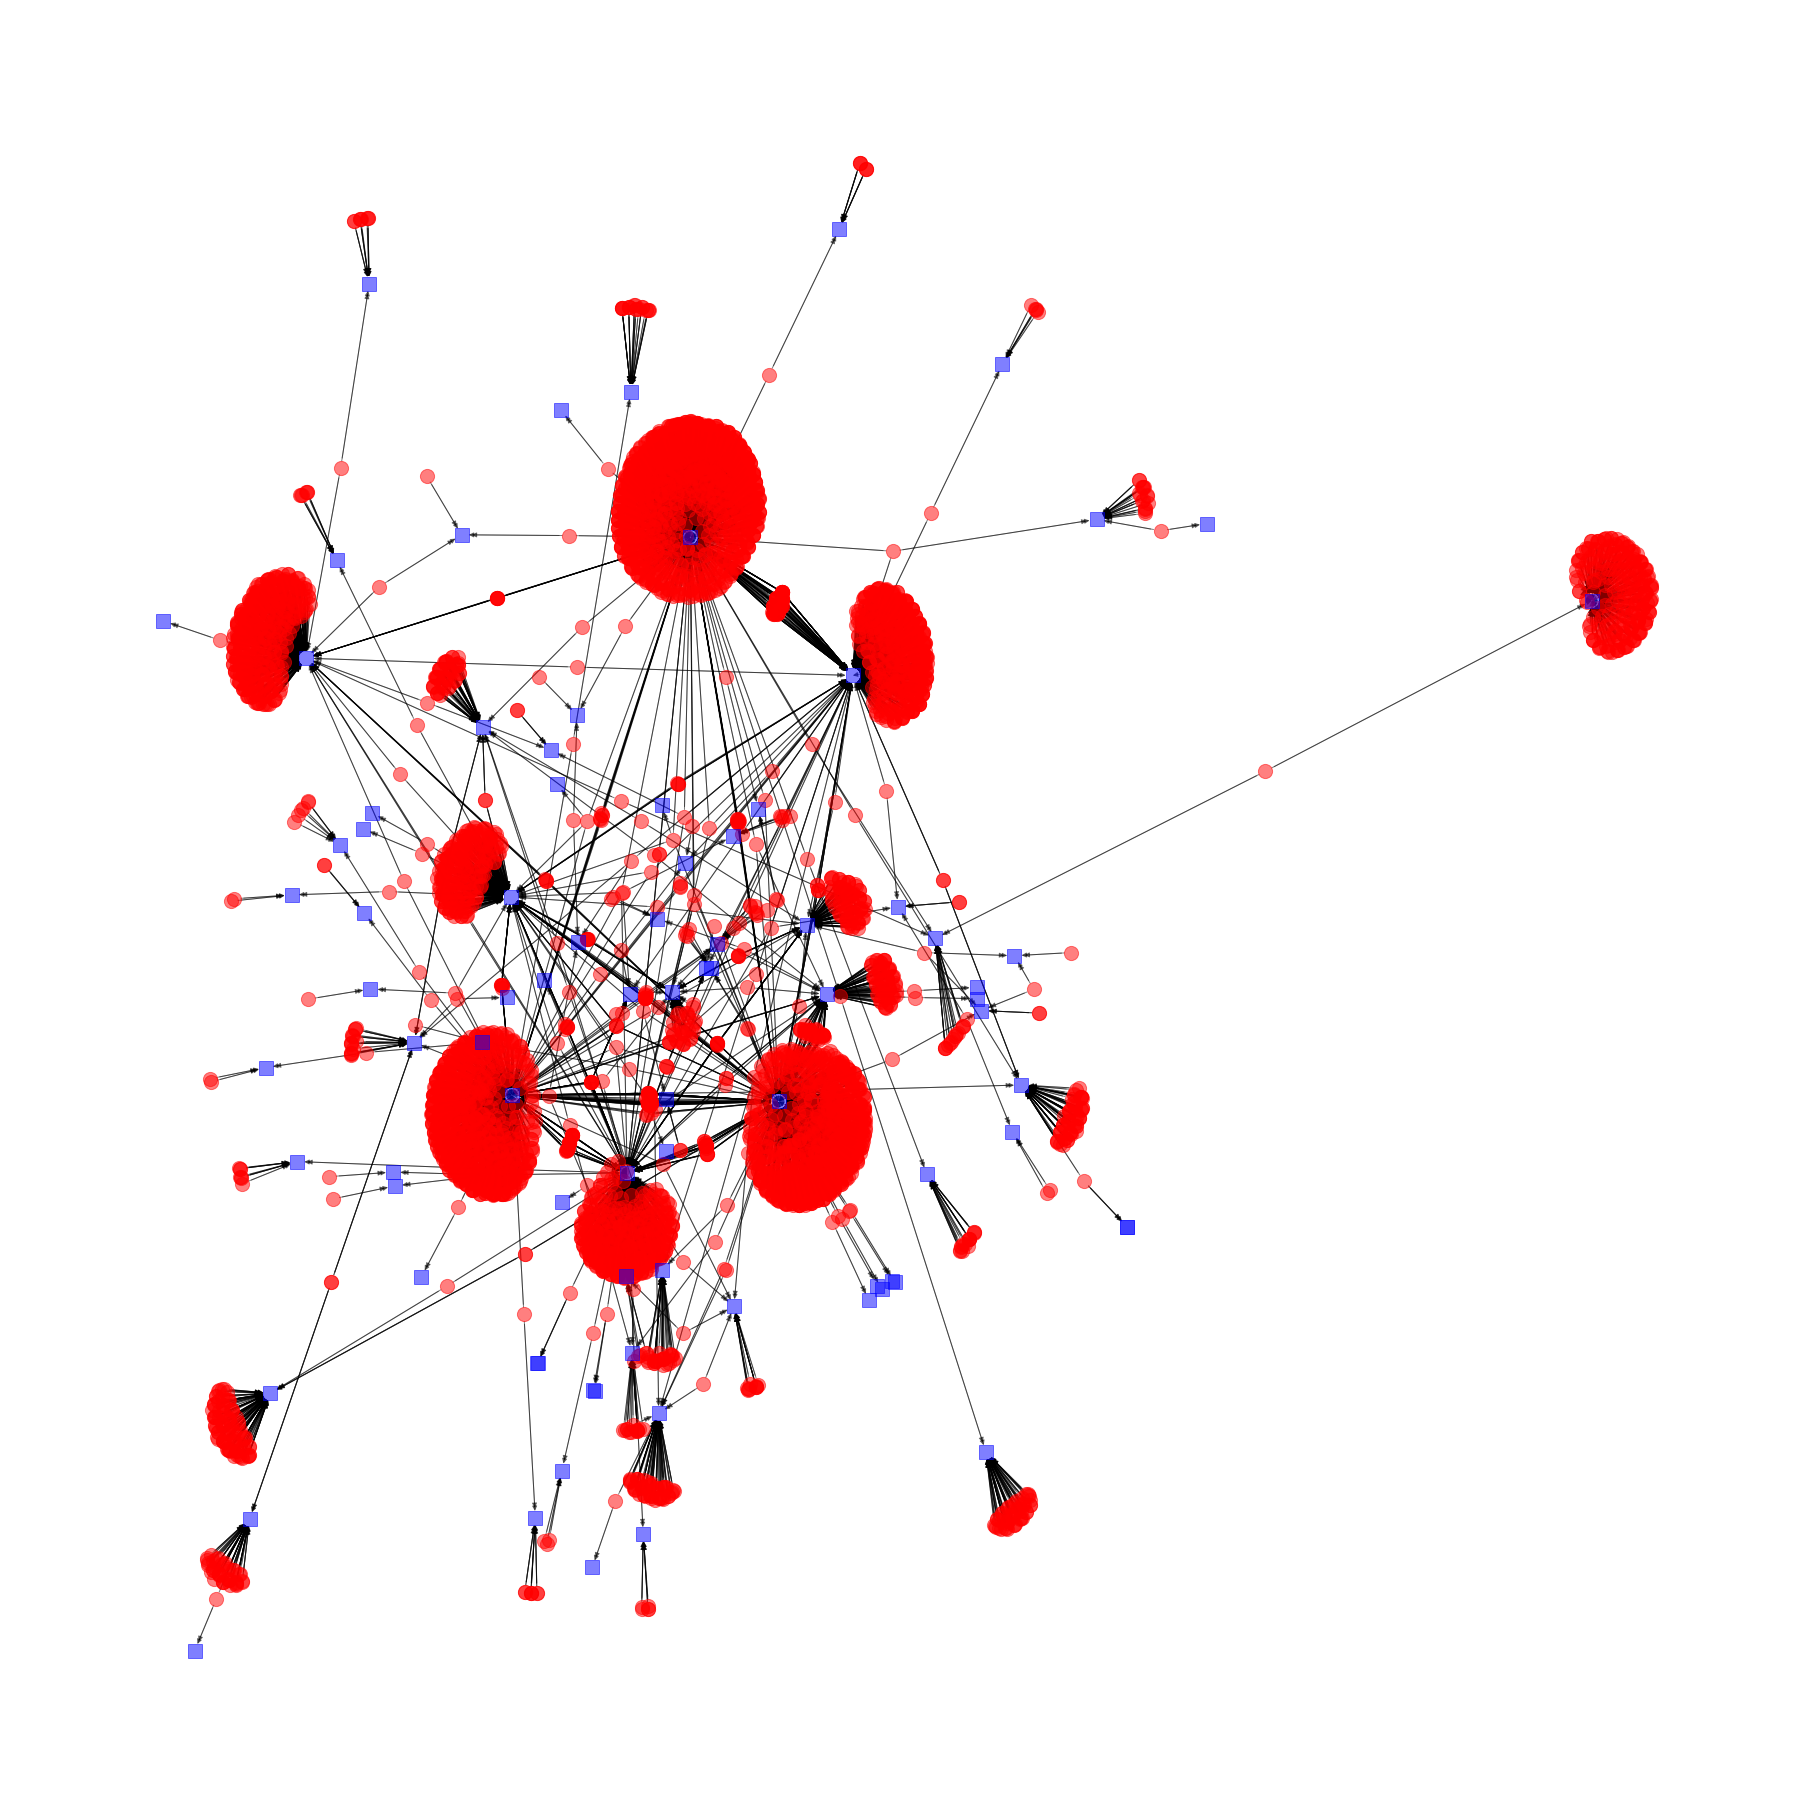

In [22]:
plt.figure(figsize=(25, 25))

B = nx.Graph(seed=1)
B.add_nodes_from(gcc_users, bipartite=0)
B.add_nodes_from(gcc_contracts, bipartite=1)
B.add_edges_from(gcc_edges)

pos=nx.spring_layout(B)#, k=0.15

# draw the network - user nodes
nx.draw(B,
        pos,
        arrows=True,
        nodelist=list(gcc_users),
        node_color='red',
        alpha=0.5,        
        # with_labels=True,
        # font_size=24,
        node_size=200)

# draw the network - contract nodes
nx.draw(B,
        pos,
        arrows=True,
        nodelist=list(gcc_contracts),
        node_color='blue',
        alpha=0.5,        
        node_shape='s',
        # with_labels=True,
        # font_size=24,
        node_size=200)

# show the plot
plt.show()